In [1]:
import sys, os
sys.path.append('../vysxd')
from vysxd_analysis import *
from vysxd_define import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

In [2]:
b1_path = 'data/MS/FLD/part_b1/'
b2_path = 'data/MS/FLD/part_b2/'
b3_path = 'data/MS/FLD/part_b3/'

b1 = get_osiris_quantity_1d(b1_path)
b1_0 = vysxd_get_data(f'{b1_path}part_b1-000000.h5') ##can use this for easy labeling

b2 = get_osiris_quantity_1d(b2_path)
b2_0 = vysxd_get_data(f'{b2_path}part_b2-000000.h5')

b3 = get_osiris_quantity_1d(b3_path)
b3_0 = vysxd_get_data(f'{b3_path}part_b3-000000.h5')

# plt.plot(b1.X, b1.DATA, label = b1.DATA_NAME)
# plt.xlabel(f'{b1.AXIS1_NAME} [${b1.AXIS1_UNITS}$]')

In [3]:
e1_path = 'data/MS/FLD/part_e1/'
e2_path = 'data/MS/FLD/part_e2/'
e3_path = 'data/MS/FLD/part_e3/'

e1 = get_osiris_quantity_1d(e1_path)
e1_0 = vysxd_get_data(f'{e1_path}part_e1-000000.h5') ##can use this for easy labeling

e2 = get_osiris_quantity_1d(e2_path)
e2_0 = vysxd_get_data(f'{e2_path}part_e2-000000.h5')

e3 = get_osiris_quantity_1d(e3_path)
e3_0 = vysxd_get_data(f'{e3_path}part_e3-000000.h5')

In [4]:
np.shape(b1[0]) # = (460,512) this is  your quantity of interest... or is it
np.shape(b1[3]) # = (460,) this is the t coordinate
np.shape(b1[4]) # = (512,) this is the x coordinate

(512,)

In [5]:
def plot_quantity(q, q0 = ''):
    plt.figure()
    plt.imshow(np.transpose(q[0]), origin='lower', extent=[q[3][0], q[3][-1], q[4][0], q[4][-1]], aspect='auto')
    if (q0 != ''):
        plt.ylabel(f'{q0.AXIS1_NAME} [${q0.AXIS1_UNITS}$]')
        plt.xlabel(f'Time [${q0.TIME_UNITS}$]')
        plt.colorbar(label=q0.DATA_NAME)

<Figure size 640x480 with 0 Axes>

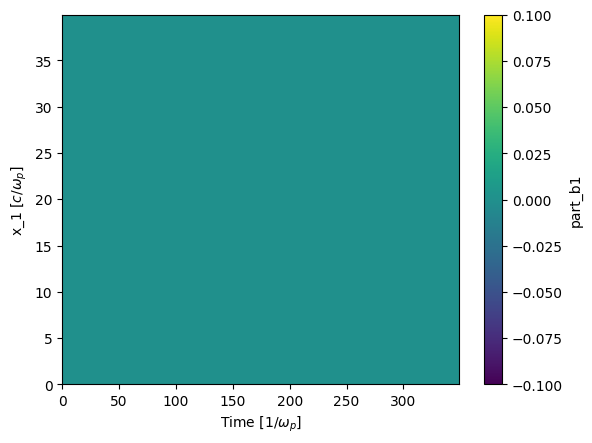

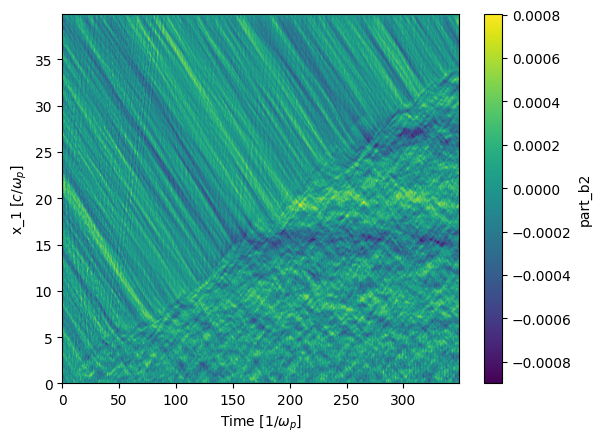

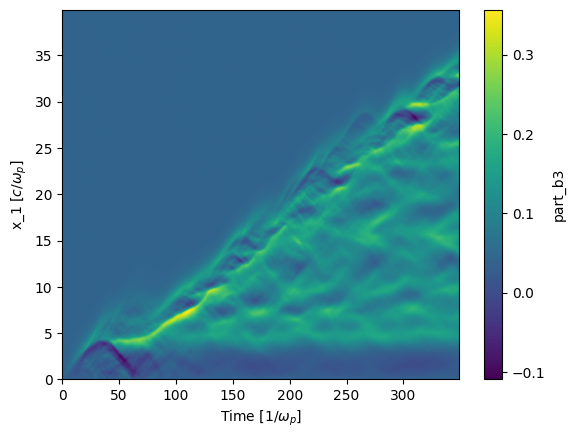

In [6]:
plt.tight_layout()
plot_quantity(b1,b1_0)
plot_quantity(b2,b2_0)
plot_quantity(b3,b3_0)

What about the RH jump conditions for the E field? Do we see continuity of the transverse E field?

<Figure size 640x480 with 0 Axes>

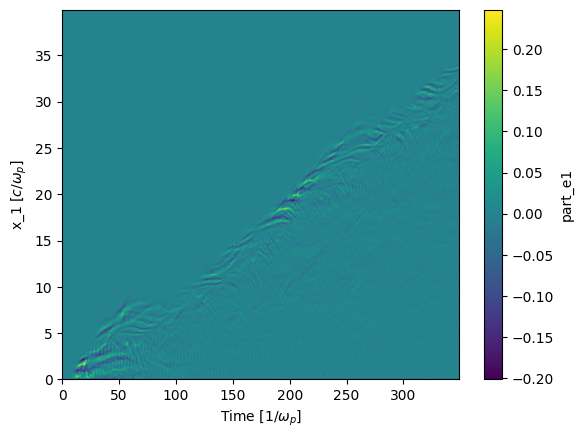

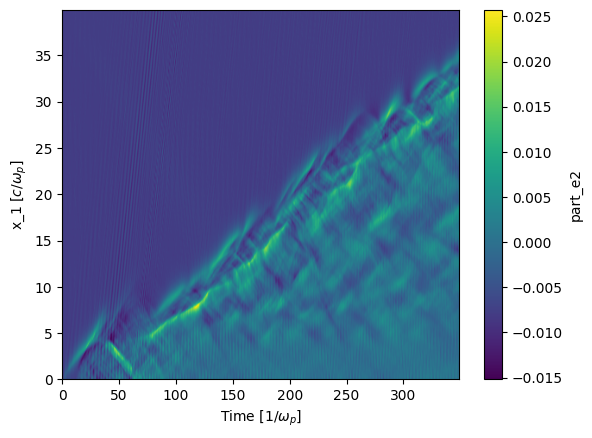

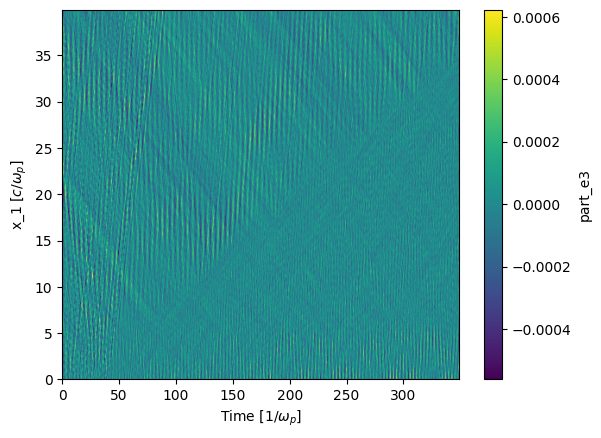

In [7]:
plt.tight_layout()
plot_quantity(e1,e1_0)
plot_quantity(e2,e2_0)
plot_quantity(e3,e3_0)

Let's try to overlay the shock velocity $v_s$ on top of these graphs... Just by trial and error, it looks like the solution is in this range

In [13]:
shockspeed_lower_bound = .1
shockspeed_upper_bound = .09

(0.0, 40.0)

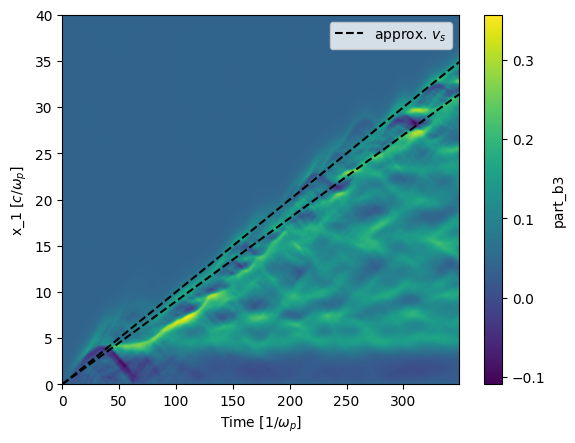

In [14]:
plot_quantity(b3,b3_0)
plt.plot(b3[3], b3[3]*shockspeed_lower_bound,c = 'black', linestyle = 'dashed')
plt.plot(b3[3], b3[3]*shockspeed_upper_bound,c = 'black', linestyle = 'dashed', label = "approx. $v_s$")
plt.legend()
plt.ylim(0,40)


(0.0, 40.0)

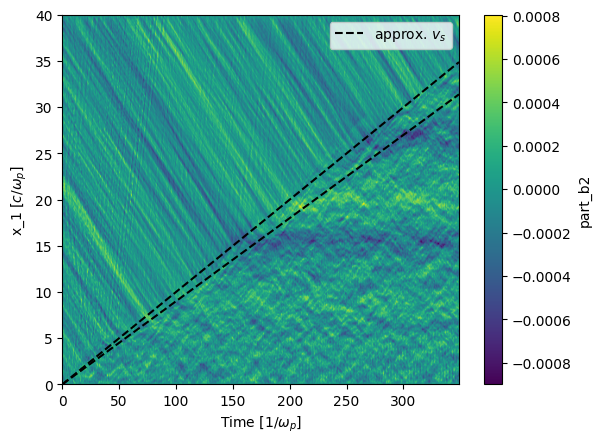

In [15]:
plot_quantity(b2,b2_0)
plt.plot(b2[3], b2[3]*shockspeed_lower_bound, c = 'black', linestyle = 'dashed')
plt.plot(b2[3], b2[3]*shockspeed_upper_bound, c = 'black', linestyle = 'dashed', label = "approx. $v_s$")
plt.legend()
plt.ylim(0,40)


(0.0, 40.0)

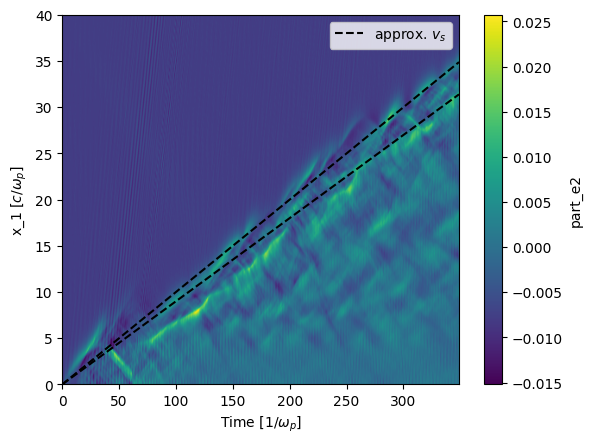

In [16]:
plot_quantity(e2,e2_0)
plt.plot(e2[3], e2[3]*shockspeed_lower_bound, c = 'black', linestyle = 'dashed')
plt.plot(e2[3], e2[3]*shockspeed_upper_bound, c = 'black', linestyle = 'dashed', label = "approx. $v_s$")
plt.legend()
plt.ylim(0,40)


In [17]:
def field_transform(v: float, e_: np.array, b_: np.array):
    gamma = 1/np.sqrt(1-v**2)

    e1 = e_[0]
    b1 = b_[0]

    e2 = gamma*(e_[1] + v*b_[2])
    b2 = gamma*(b_[1] - v*e_[2])

    e3 = gamma*(e_[2] - v*b_[1])
    b3 = gamma*(b_[2] + v*e_[1])
    return [e1,e2,e3], [b1,b2,b3]

In [12]:
eprime, bprime = field_transform(v = .1, e_ = np.array([e1[0],e2[0],e3[0]]), b_ = np.array([b1[0],b2[0],b3[0]]))

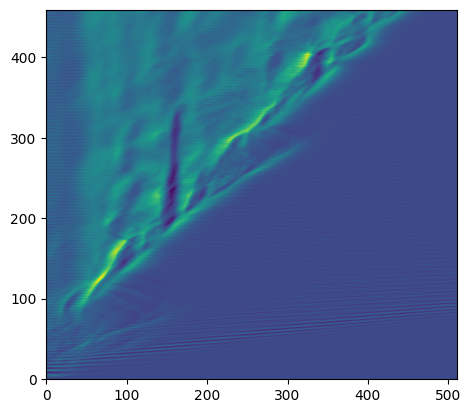

In [13]:
plt.tight_layout()
plt.imshow(eprime[1], origin = 'lower')


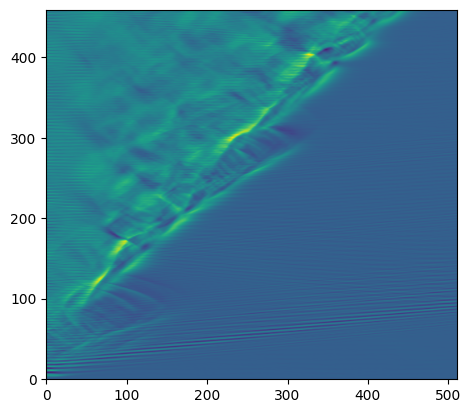

In [14]:
plt.imshow(e2[0], origin = 'lower')

Figure out how to transform coordinates

In [17]:
from scipy.interpolate import RegularGridInterpolator

def coordinate_transform(v: float, e: tuple, b: tuple):

    # Note that x_ and t_ aren't necessarily the same size
    # After transformation, x and t won't necessarily be evenly distributed, but we require that they
    # are the same size as when we began

    xprime = np.linspace(min(x)-v*max(t), max(x), len(x))

    E_f = RegularGridInterpolator([t,xprime], e[0])
    B_f = RegularGridInterpolator([t,xprime], b[0])
    
    Eprime = np.empty((len(t),len(x)))
    Bprime = np.empty((len(t),len(x)))

    for i in range(len(t)):
        for j in range(len(x)):
            Eprime[i,j] = E_f([t[i], x[j]-v*t[i]])
            Bprime[i,j] = B_f([t[i], x[j]-v*t[i]])

    return Eprime, Bprime, xprime

In [18]:
Eprime, bprime, xprime = coordinate_transform(4.0,e2,b2) ##why isn't this working


plt.figure()
plt.imshow(Eprime, origin='lower', extent=[e1[3][0], e1[3][-1], xprime[0], xprime[-1]], aspect='auto')
# if (q0 != ''):
#     plt.ylabel(f'{q0.AXIS1_NAME} [${q0.AXIS1_UNITS}$]')
#     plt.xlabel(f'Time [${q0.TIME_UNITS}$]')
#     plt.colorbar(label=q0.DATA_NAME)

NameError: name 'x' is not defined

In [113]:
np.shape(e1[0]) # = (460, 512)

e1_f = RegularGridInterpolator([e1[3],e1[4]],e1[0])

xnew = np.linspace(0,max(e1[4]),100)
tnew = np.linspace(0,max(e1[3]),100)
e1_f([max(e1[3])+1,xnew[5]])

ValueError: One of the requested xi is out of bounds in dimension 0